# COMP4211 - Assignment 1

In [136]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import re
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import time
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

## Part 1: Data Exploration and Preparation

In [137]:
# Loading the data.

df = pd.read_csv("data.csv")
bonus_df = df.copy()

## Q1: Dataset Overview

In [138]:
df.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,reg_target,class_target
0,male,22.0,1,0,A/5 21171,NaN,S,Lower Class,"Braund, Mr. Owen Harris",7.2500,0
1,female,38.0,1,0,PC 17599,C85,C,Upper Class,"Cumings, Mrs. John Bradley (Florence Briggs Th...",71.2833,1
2,female,26.0,0,0,STON/O2. 3101282,NaN,S,Lower Class,"Heikkinen, Miss. Laina",7.9250,1
3,female,35.0,1,0,113803,C123,S,Upper Class,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",53.1000,1
4,male,35.0,0,0,373450,NaN,S,Lower Class,"Allen, Mr. William Henry",8.0500,0


In [139]:
# Number of rows and columns in dataset.

print(f"Shape of dataframe: {df.shape}")

Shape of dataframe: (891, 11)


In [140]:
# Size of dataset (total number of elements in the DataFrame)

print(f"The size of the dataset: {df.size}")

The size of the dataset: 9801


In [141]:
# Missing values for each column.

missing_values = df.isna().sum()
missing_values

c1                0
c2              177
c3                0
c4                0
c5                0
c6              687
c7                2
c8                0
c9                0
reg_target        0
class_target      0
dtype: int64

In [142]:
# Proportion of missing values.

total_values = df.shape[0]


proportion_missing = missing_values / total_values

proportion_missing

c1              0.000000
c2              0.198653
c3              0.000000
c4              0.000000
c5              0.000000
c6              0.771044
c7              0.002245
c8              0.000000
c9              0.000000
reg_target      0.000000
class_target    0.000000
dtype: float64

## Q2: Feature Distribution

In [143]:
# Column data types. 

df.dtypes

c1               object
c2              float64
c3                int64
c4                int64
c5               object
c6               object
c7               object
c8               object
c9               object
reg_target      float64
class_target      int64
dtype: object

#### Numerical features

In [144]:
# Numerical features.
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Checking for continuous and discrete features
continuous_features = []
discrete_features = []

for col in numerical_features: 
    
    unique_values = df[col].nunique()
    
    # If unique values < 10 we say feature is discrete.
    if unique_values < 10:  
        discrete_features.append(col)
    else: 
        continuous_features.append(col)

# first-in-order numerical feature is c2.
print("Numerical Features:", numerical_features) 
print("Continuous Features:", continuous_features)
print("Discrete Features:", discrete_features)

Numerical Features: ['c2', 'c3', 'c4', 'reg_target', 'class_target']
Continuous Features: ['c2', 'reg_target']
Discrete Features: ['c3', 'c4', 'class_target']


In [145]:
# Summarize statistical distribution of all numerical features.

df[numerical_features].describe()

,c2,c3,c4,reg_target,class_target
count,714.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208,0.383838
std,14.526497,1.102743,0.806057,49.693429,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,0.000000,31.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000


c2


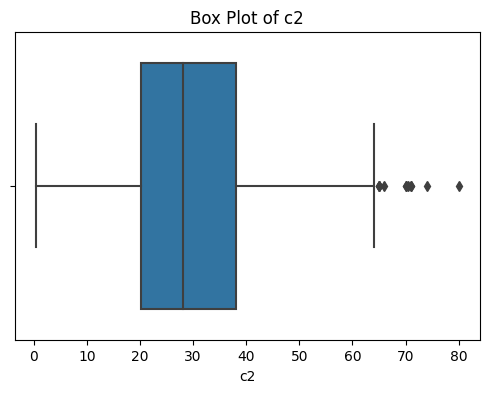

In [146]:
# Visualizing first-in-order numerical feature using a boxplot.

first_feature = numerical_features[0]   # feature c2
print(first_feature)

# Creating a box plot.
plt.figure(figsize=(6, 4))
sns.boxplot(x=df[first_feature])
plt.title(f"Box Plot of {first_feature}")
plt.xlabel(first_feature)
plt.show()

#### Categorical Features

In [147]:
# The Categorical Features are the ones that are not numerical.
list_categorical_features = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Categorical Features:", list_categorical_features)


Categorical Features: ['c1', 'c5', 'c6', 'c7', 'c8', 'c9']


Binary Features: ['c1']
Ordinal Features: ['c8']
Nominal Features: ['c5', 'c6', 'c7', 'c9']

Count of Categories for Each Categorical Feature:
 c1      2
c5    681
c6    147
c7      3
c8      3
c9    891
dtype: int64


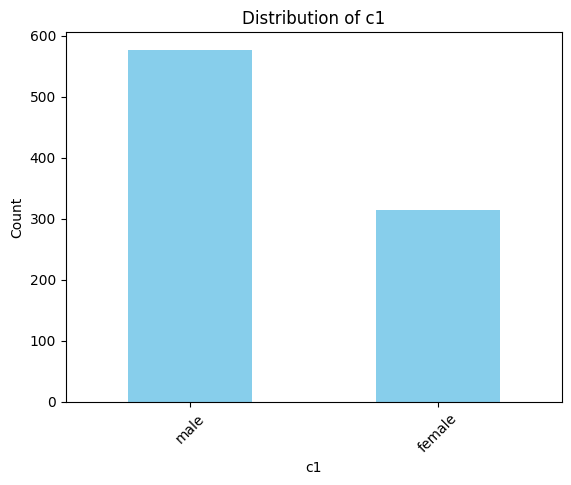

In [148]:
# The Categorical Features are the ones that are not numerical.
list_categorical_features = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

binary_features = [col for col in list_categorical_features if df[col].nunique() == 2]

ordinal_features = [col for col in list_categorical_features if df[col].dtype.name == 'category']

# If Python misinterprets c8, add it manually.
if 'c8' in list_categorical_features and 'c8' not in ordinal_features:
    ordinal_features.append('c8')

nominal_features = [col for col in list_categorical_features if col not in binary_features + ordinal_features]
 
print("Binary Features:", binary_features)
print("Ordinal Features:", ordinal_features)
print("Nominal Features:", nominal_features)

# Summarizing count of features.
category_counts = df[list_categorical_features].nunique()
print("\nCount of Categories for Each Categorical Feature:\n", category_counts)

first_categorical_feature = list_categorical_features[0]
df[first_categorical_feature].value_counts().plot(kind='bar', color='skyblue')

plt.title(f'Distribution of {first_categorical_feature}')
plt.xlabel(first_categorical_feature)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Q3: Correlation Analysis 

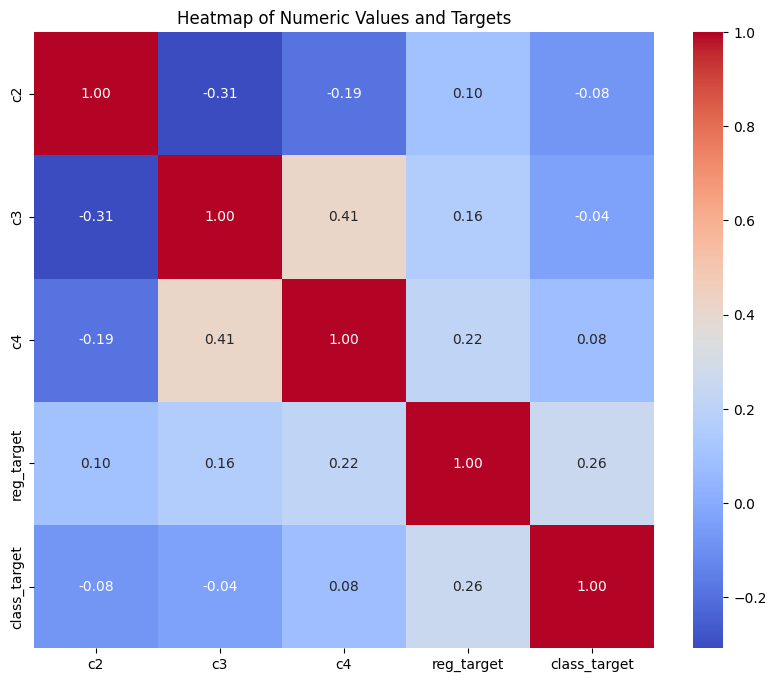

In [149]:
# Concatenate the numerical features with the additional features
correlation_features = df[numerical_features]

# Calculate the correlation matrix
correlation_matrix = correlation_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Heatmap of Numeric Values and Targets")
plt.show()

## Part 2: Data Preprocessing Techniques

## [Q4] Handling missing values


In [150]:
# Checking proportion of missing values. 
missing_proportion = df.isnull().mean() * 100
print("Proportion of Missing Values for Each Feature:")
print(missing_proportion)

# Highlighting features with more than 70% missing values.
high_missing_features = missing_proportion[missing_proportion >= 70]
print("\nFeatures with ≥ 70% Missing Values:")
print(high_missing_features)

Proportion of Missing Values for Each Feature:
c1               0.000000
c2              19.865320
c3               0.000000
c4               0.000000
c5               0.000000
c6              77.104377
c7               0.224467
c8               0.000000
c9               0.000000
reg_target       0.000000
class_target     0.000000
dtype: float64

Features with ≥ 70% Missing Values:
c6    77.104377
dtype: float64


In [151]:
# Dropping feature c6 because it has >70% NaN values
df = df.drop(["c6"], axis=1)

# Median imputation for c2 because it has a moderate amount of missing values.
median_imputer = SimpleImputer(strategy='median')
df['c2'] = median_imputer.fit_transform(df[['c2']])

# Mode imputation for c7 because it has a small amount of missing values.
mode_imputer = SimpleImputer(strategy='most_frequent')
df['c7'] = mode_imputer.fit_transform(df[['c7']]).ravel()

# No more missing values.
print(df.isna().sum())


c1              0
c2              0
c3              0
c4              0
c5              0
c7              0
c8              0
c9              0
reg_target      0
class_target    0
dtype: int64


## [Q5] Normalization and Standardization of first-in-order feature

In [152]:
first_feature = 'c2' # first in order numerical feature. 

print("Before processing:")
print(df[first_feature].head(10))

df_scaled = df.copy()  # Create a copy of the original dataframe

standard_scaler = StandardScaler()
df_scaled[first_feature + '_standard'] = standard_scaler.fit_transform(df[[first_feature]])

minmax_scaler = MinMaxScaler()
df_scaled[first_feature + '_minmax'] = minmax_scaler.fit_transform(df[[first_feature]])

robust_scaler = RobustScaler()
df_scaled[first_feature + '_robust'] = robust_scaler.fit_transform(df[[first_feature]])


# Display the first 10 samples after processing in the new dataframe
print("\nAfter processing with StandardScaler:")
print(df_scaled[first_feature + '_standard'].head(10))

print("\nAfter processing with MinMaxScaler:")
print(df_scaled[first_feature + '_minmax'].head(10))

print("\nAfter processing with RobustScaler:")
print(df_scaled[first_feature + '_robust'].head(10))


print("\nThe new dataframe with scaled features:")
print(df_scaled.head(10))


Before processing:
0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5    28.0
6    54.0
7     2.0
8    27.0
9    14.0
Name: c2, dtype: float64

After processing with StandardScaler:
0   -0.565736
1    0.663861
2   -0.258337
3    0.433312
4    0.433312
5   -0.104637
6    1.893459
7   -2.102733
8   -0.181487
9   -1.180535
Name: c2_standard, dtype: float64

After processing with MinMaxScaler:
0    0.271174
1    0.472229
2    0.321438
3    0.434531
4    0.434531
5    0.346569
6    0.673285
7    0.019854
8    0.334004
9    0.170646
Name: c2_minmax, dtype: float64

After processing with RobustScaler:
0   -0.461538
1    0.769231
2   -0.153846
3    0.538462
4    0.538462
5    0.000000
6    2.000000
7   -2.000000
8   -0.076923
9   -1.076923
Name: c2_robust, dtype: float64

The new dataframe with scaled features:
       c1    c2  c3  c4                c5 c7            c8  \
0    male  22.0   1   0         A/5 21171  S   Lower Class   
1  female  38.0   1   0          PC 17599  C   Upper Class  

## [Q6] Encoding categorical variables 

#### First: remove features with more than 70% unique values.

In [153]:
copy_df = df.copy()

categorical_features = df.select_dtypes(include=["object"])

unique_percentage = categorical_features.nunique() / len(df) * 100

# c5 and c9 are dropped because they are over the limit.
columns_to_drop = unique_percentage[unique_percentage > 70].index

df = df.drop(columns=columns_to_drop)
print("Updated DataFrame:")
(df.head())


Updated DataFrame:


,c1,c2,c3,c4,c7,c8,reg_target,class_target
0,male,22.0,1,0,S,Lower Class,7.2500,0
1,female,38.0,1,0,C,Upper Class,71.2833,1
2,female,26.0,0,0,S,Lower Class,7.9250,1
3,female,35.0,1,0,S,Upper Class,53.1000,1
4,male,35.0,0,0,S,Lower Class,8.0500,0


#### Encoding Categorical Variables

In [154]:
# First in order categorical feature.
print("First-in-order categorical feature (before encoding):")
print(df[['c1']].head(10))

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  

encoded_c1 = onehot_encoder.fit_transform(df[['c1']])

encoded_c1_df = pd.DataFrame(encoded_c1, columns=onehot_encoder.get_feature_names_out(['c1']))

# Drop old c1 feature.
df = df.drop(columns=['c1'])

df = pd.concat([encoded_c1_df, df], axis=1)

ordinal_columns = ['c8'] 
ordinal_encoder = OrdinalEncoder(categories=[["Lower Class", "Middle Class", "Upper Class"]])
df[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])


nominal_columns = ['c7'] 
onehot_encoder_nominal = OneHotEncoder(drop='first', sparse_output=False)
encoded_nominal = onehot_encoder_nominal.fit_transform(df[nominal_columns])


encoded_nominal_df = pd.DataFrame(encoded_nominal, columns=onehot_encoder_nominal.get_feature_names_out(nominal_columns))

df = df.drop(columns=nominal_columns)
df = pd.concat([df, encoded_nominal_df], axis=1)


print("\nFirst-in-order categorical feature (after encoding):")
print(df[['c1_male']].head(10))

First-in-order categorical feature (before encoding):
       c1
0    male
1  female
2  female
3  female
4    male
5    male
6    male
7    male
8  female
9  female

First-in-order categorical feature (after encoding):
   c1_male
0      1.0
1      0.0
2      0.0
3      0.0
4      1.0
5      1.0
6      1.0
7      1.0
8      0.0
9      0.0


## [Q7] Future Engineering

In [155]:
# Extracting tiles from feature c9.
def extract_titles(name):
    titles = ['Mr', 'Mrs', 'Master', 'Miss']
    
    title_dict = {title: 0 for title in titles}
    
    for title in titles:
        if re.search(r'\b' + title + r'\b', name):  
            title_dict[title] = 1
    
    return title_dict

title_columns = copy_df['c9'].apply(extract_titles).apply(pd.Series)

copy_df = pd.concat([copy_df, title_columns], axis=1)

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_c1 = onehot_encoder.fit_transform(copy_df[['c1']])


encoded_c1_df = pd.DataFrame(encoded_c1, columns=onehot_encoder.get_feature_names_out(['c1']))

df_copy = pd.concat([copy_df, encoded_c1_df], axis=1)
df_copy = df_copy.drop(columns=['c1'])

df = pd.concat([df, title_columns], axis=1)

df.head()

,c1_male,c2,c3,c4,c8,reg_target,class_target,c7_Q,c7_S,Mr,Mrs,Master,Miss
0,1.0,22.0,1,0,0.0,7.2500,0,0.0,1.0,1,0,0,0
1,0.0,38.0,1,0,2.0,71.2833,1,0.0,0.0,0,1,0,0
2,0.0,26.0,0,0,0.0,7.9250,1,0.0,1.0,0,0,0,1
3,0.0,35.0,1,0,2.0,53.1000,1,0.0,1.0,0,1,0,0
4,1.0,35.0,0,0,0.0,8.0500,0,0.0,1.0,1,0,0,0


## Part 3: Regression

In [156]:
seed = 4211

# All features except target variables.
X = df.drop("reg_target", axis=1)

# target variable in regression model.
y = df["reg_target"] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Check the shapes of the resulting sets
print("Training set features shape:", X_train.shape)
print("Validation set features shape:", X_val.shape)
print("Training set target shape:", y_train.shape)
print("Validation set target shape:", y_val.shape)

Training set features shape: (712, 12)
Validation set features shape: (179, 12)
Training set target shape: (712,)
Validation set target shape: (179,)


#### [Q8] Results on validation data.

In [157]:
features = ['c2', "c3", "c4", 'c8']  # c2, c3 and c4 are numerical, c8 is ordinal.
validation_results = {}

for feature in features:
    X_val_feature = X_val[[feature]]  
    y_val_copy = y_val 

    model = LinearRegression()
    model.fit(X_train[[feature]], y_train)

    y_val_pred = model.predict(X_val_feature)

    r_squared_val = model.score(X_val_feature, y_val_copy)
    mse_val = mean_squared_error(y_val_copy, y_val_pred)

    validation_results[feature] = {
        'r_squared': r_squared_val,
        'mse': mse_val
    }

print("\n------------------VALIDATION DATA RESULTS---------------------\n")

for model_number, (feature, result) in enumerate(validation_results.items(), start=1):

    # Relevant results. 
    print(f'Regression Model {model_number}')
    print(f"Feature: {feature}")
    print(f"  R-squared: {result['r_squared']:.4f}")  
    print(f"  Mean Squared Error (MSE): {result['mse']:.4f}\n")  


X_train_all = X_train[features]
X_val_all = X_val[features]

combined_model = LinearRegression()
combined_model.fit(X_train_all, y_train)

y_val_pred_combined = combined_model.predict(X_val_all)

r_squared_combined = combined_model.score(X_val_all, y_val)
mse_combined = mean_squared_error(y_val, y_val_pred_combined)


# Reporting results on validation data.
print("Combined model with all features:")
print(f"  R-squared: {r_squared_combined}")
print(f"  Mean Squared Error (MSE): {mse_combined}")


------------------VALIDATION DATA RESULTS---------------------

Regression Model 1
Feature: c2
  R-squared: -0.0007
  Mean Squared Error (MSE): 3661.0534

Regression Model 2
Feature: c3
  R-squared: 0.0018
  Mean Squared Error (MSE): 3651.8049

Regression Model 3
Feature: c4
  R-squared: 0.0388
  Mean Squared Error (MSE): 3516.5773

Regression Model 4
Feature: c8
  R-squared: 0.2986
  Mean Squared Error (MSE): 2565.9937

Combined model with all features:
  R-squared: 0.3535085801101705
  Mean Squared Error (MSE): 2365.1076480015345


## [Q9]

In [158]:
updated_features = ["c2", "c3", "c4", "c8", "c7_Q", "c7_S"]  # Now the encoded version of c7 (c7_Q and c7_S) will be added to the linear regression model.

X_train_updated = X_train[updated_features]  
X_val_updated = X_val[updated_features]      

# Importing timer to time model training time.
start_time = time.time()
model_updated = LinearRegression()
model_updated.fit(X_train_updated, y_train)
training_time = time.time() - start_time  

y_val_pred_updated = model_updated.predict(X_val_updated)

r_squared_updated = model_updated.score(X_val_updated, y_val)
mse_updated = mean_squared_error(y_val, y_val_pred_updated)

# Reporting results.
print("\nUpdated regression model with c2, c3, c4, c8, and c7:\n")
print(f"  Training Time: {training_time:.4f} seconds")
print(f"  R-squared: {r_squared_updated:.4f}")
print(f"  Mean Squared Error (MSE): {mse_updated:.4f}")


Updated regression model with c2, c3, c4, c8, and c7:

  Training Time: 0.0020 seconds
  R-squared: 0.3827
  Mean Squared Error (MSE): 2258.4838


##  [Q11] Feedforward Neural Networks


Training model with 1 hidden units...
Training Time: 0.28 seconds
R² Score on Validation Set: -0.3701
Mean Squared Error (MSE): 5012.2734

Training model with 8 hidden units...
Training Time: 0.29 seconds
R² Score on Validation Set: 0.3888
Mean Squared Error (MSE): 2235.8989

Training model with 32 hidden units...
Training Time: 0.16 seconds
R² Score on Validation Set: 0.3946
Mean Squared Error (MSE): 2214.6793

Training model with 128 hidden units...
Training Time: 1.87 seconds
R² Score on Validation Set: 0.3892
Mean Squared Error (MSE): 2234.4316


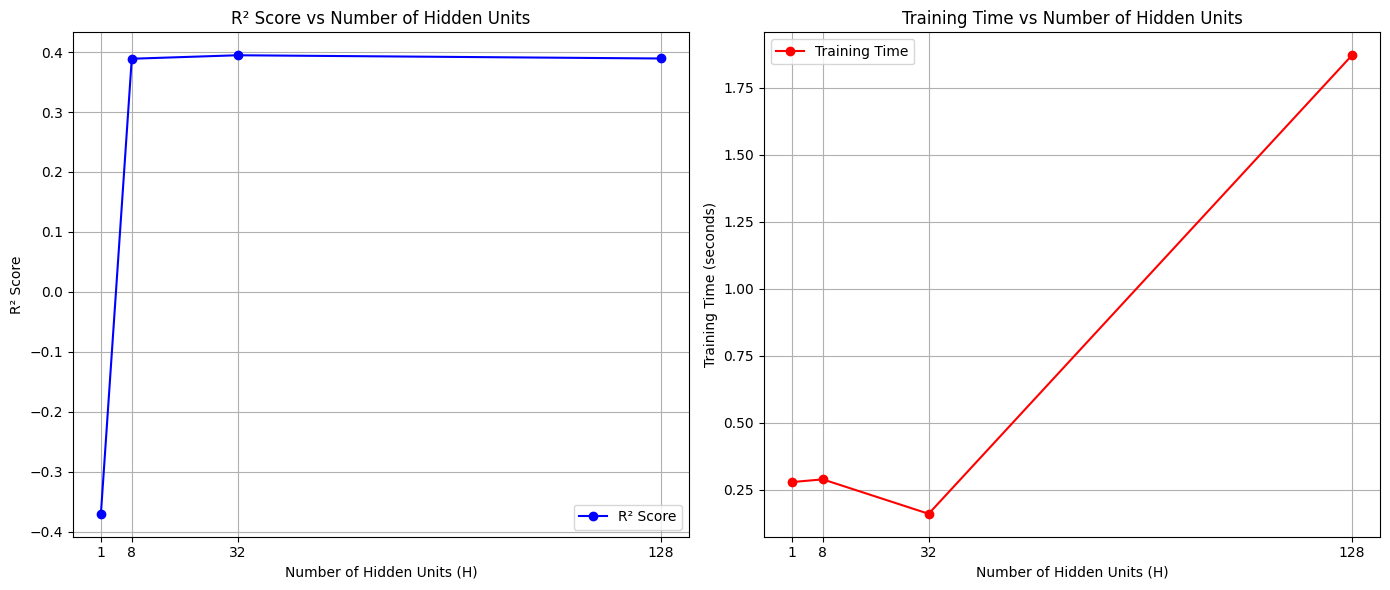

In [159]:
# Features and target variable
features_Q8 = ["c2", "c3", "c4", "c8"]
X_train = X_train[features_Q8]  
X_val = X_val[features_Q8]      
y_train = y_train               
y_val = y_val                   

# Hidden units specified in assignment description.
hidden_units_options = [1, 8, 32, 128]

r2_scores = []  
mse_scores = []  
training_times = []  

for H in hidden_units_options:
    print(f"\nTraining model with {H} hidden units...")

    model = MLPRegressor(
        hidden_layer_sizes=(H, H, H),
        early_stopping=True,
        max_iter=1000,
        random_state=4211,
        solver='adam',  
        tol=1e-4,  
        n_iter_no_change=10  
    )

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    training_times.append(training_time)

    y_val_pred = model.predict(X_val)

    r2 = r2_score(y_val, y_val_pred)
    r2_scores.append(r2)

    mse = mean_squared_error(y_val, y_val_pred)
    mse_scores.append(mse)

    print(f"Training Time: {training_time:.2f} seconds")
    print(f"R² Score on Validation Set: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.plot(hidden_units_options, r2_scores, marker='o', color='b', label='R² Score')
ax1.set_title('R² Score vs Number of Hidden Units')
ax1.set_xlabel('Number of Hidden Units (H)')
ax1.set_ylabel('R² Score')
ax1.grid(True)
ax1.set_xticks(hidden_units_options)
ax1.legend()


ax2.plot(hidden_units_options, training_times, marker='o', color='r', label='Training Time')
ax2.set_title('Training Time vs Number of Hidden Units')
ax2.set_xlabel('Number of Hidden Units (H)')
ax2.set_ylabel('Training Time (seconds)')
ax2.grid(True)
ax2.set_xticks(hidden_units_options)
ax2.legend()

plt.tight_layout()
plt.show()


## Part 4: Classification

## [Q13] & [Q14] Model Results, ROC Curve and AUC score


Training model with eta0 = 1.5...


Logistic Regression Model Results:
  Learning Rate (eta0): 1.5
  Training Time: 0.0010 seconds
  Accuracy: 0.6648
  F1 Score: 0.4000

Training model with eta0 = 2.0...


Logistic Regression Model Results:
  Learning Rate (eta0): 2.0
  Training Time: 0.0000 seconds
  Accuracy: 0.7318
  F1 Score: 0.5789

Training model with eta0 = 5.0...


Logistic Regression Model Results:
  Learning Rate (eta0): 5.0
  Training Time: 0.0000 seconds
  Accuracy: 0.6089
  F1 Score: 0.3750


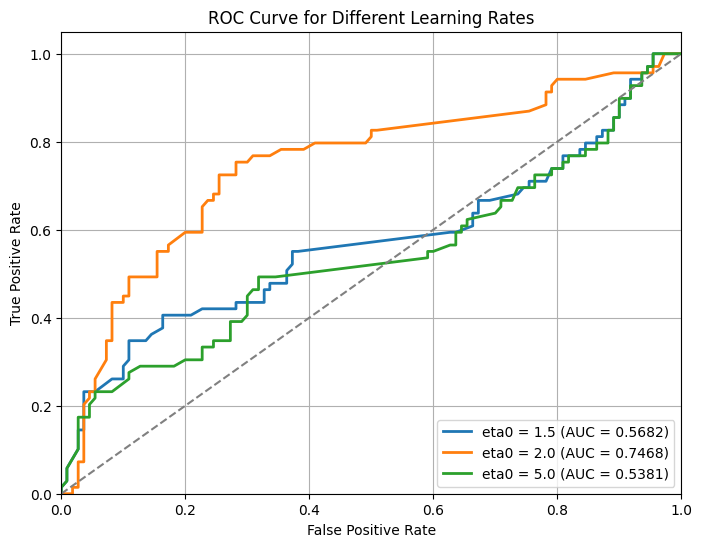

In [160]:
features_Q8 = ["c2", "c3", "c4", "c8"]
X = df[features_Q8].values
y = df["class_target"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

eta_values = [1.5, 2.0, 5.0]

plt.figure(figsize=(8, 6))

for eta in eta_values:
    print(f"\nTraining model with eta0 = {eta}...\n")

    model = SGDClassifier(loss="log_loss", learning_rate="constant", eta0=eta, random_state=4211)

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_val)
    y_pred_proba = model.decision_function(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    print("\nLogistic Regression Model Results:")
    print(f"  Learning Rate (eta0): {eta}")
    print(f"  Training Time: {training_time:.4f} seconds")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    plt.plot(fpr, tpr, lw=2, label=f'eta0 = {eta} (AUC = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Learning Rates')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## [Q15] & [Q16] Feedforward Neural Networks

Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6204 - loss: 0.6926 - val_accuracy: 0.6145 - val_loss: 0.6911
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6118 - loss: 0.6905 - val_accuracy: 0.6145 - val_loss: 0.6890
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6074 - loss: 0.6888 - val_accuracy: 0.6145 - val_loss: 0.6872
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6227 - loss: 0.6862 - val_accuracy: 0.6145 - val_loss: 0.6853
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6257 - loss: 0.6841 - val_accuracy: 0.6145 - val_loss: 0.6837
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6123 - loss: 0.6836 - val_accuracy: 0.6145 - val_loss: 0.6823
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6805 - val_accuracy: 0.6145 - val_loss: 0.6808
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6433 - loss: 0.6770 - val_accuracy: 0.6145 - val_loss: 0.6797
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6329 - loss: 0.6926 - val_accuracy: 0.6145 - val_loss: 0.6911
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6071 - loss: 0.6908 - val_accuracy: 0.6145 - val_loss: 0.6892
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6134 - loss: 0.6887 - val_accuracy: 0.6145 - val_loss: 0.6872
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6289 - loss: 0.6859 - val_accuracy: 0.6145 - val_loss: 0.6854
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6271 - loss: 0.6841 - val_accuracy: 0.6145 - val_loss: 0.6838
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6308 - loss: 0.6819 - val_accuracy: 0.6145 - val_loss: 0.6823
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6097 - loss: 0.6825 - val_accuracy: 0.6145 - val_loss: 0.6810
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6302 - loss: 0.6787 - val_accuracy: 0.6145 - val_loss: 0.6797
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6257 - loss: 0.6925 - val_accuracy: 0.6145 - val_loss: 0.6910
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.6907 - val_accuracy: 0.6145 - val_loss: 0.6892
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 0.6880 - val_accuracy: 0.6145 - val_loss: 0.6874
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6380 - loss: 0.6857 - val_accuracy: 0.6145 - val_loss: 0.6857
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6279 - loss: 0.6844 - val_accuracy: 0.6145 - val_loss: 0.6842
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6134 - loss: 0.6839 - val_accuracy: 0.6145 - val_loss: 0.6827
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 0.6822 - val_accuracy: 0.6145 - val_loss: 0.6813
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5974 - loss: 0.6830 - val_accuracy: 0.6145 - val_loss: 0.6801
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5562 - loss: 0.7093 - val_accuracy: 0.6983 - val_loss: 0.6798
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5565 - loss: 0.6944 - val_accuracy: 0.6872 - val_loss: 0.6761
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6328 - loss: 0.6793 - val_accuracy: 0.6872 - val_loss: 0.6691
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6294 - loss: 0.6758 - val_accuracy: 0.6927 - val_loss: 0.6596
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6653 - loss: 0.6603 - val_accuracy: 0.6927 - val_loss: 0.6476
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6413 - loss: 0.6566 - val_accuracy: 0.7095 - val_loss: 0.6349
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 0.6451 - val_accuracy: 0.7095 - val_loss: 0.6180
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6894 - loss: 0.6227 - val_accuracy: 0.7151 - val_loss: 0.6021
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6418 - loss: 0.6916 - val_accuracy: 0.6927 - val_loss: 0.6885
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.6863 - val_accuracy: 0.6816 - val_loss: 0.6793
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6667 - loss: 0.6772 - val_accuracy: 0.6760 - val_loss: 0.6686
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.6657 - val_accuracy: 0.6257 - val_loss: 0.6578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6388 - loss: 0.6527 - val_accuracy: 0.6313 - val_loss: 0.6450
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6190 - loss: 0.6483 - val_accuracy: 0.6760 - val_loss: 0.6340
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6172 - loss: 0.6409 - val_accuracy: 0.6760 - val_loss: 0.6231
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6444 - loss: 0.6419 - val_accuracy: 0.6760 - val_loss: 0.6119
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4952 - loss: 0.7263 - val_accuracy: 0.6480 - val_loss: 0.6896
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5533 - loss: 0.7145 - val_accuracy: 0.6369 - val_loss: 0.6670
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5898 - loss: 0.6810 - val_accuracy: 0.6480 - val_loss: 0.6483
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5937 - loss: 0.6682 - val_accuracy: 0.6425 - val_loss: 0.6326
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6569 - loss: 0.6505 - val_accuracy: 0.6648 - val_loss: 0.6200
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6515 - loss: 0.6529 - val_accuracy: 0.6704 - val_loss: 0.6081
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7105 - loss: 0.6210 - val_accuracy: 0.6872 - val_loss: 0.5984
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6882 - loss: 0.6263 - val_accuracy: 0.7039 - val_loss: 0.5901
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6109 - loss: 0.6724 - val_accuracy: 0.6145 - val_loss: 0.6141
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6126 - loss: 0.6164 - val_accuracy: 0.6536 - val_loss: 0.5848
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6791 - loss: 0.6133 - val_accuracy: 0.7151 - val_loss: 0.5778
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7173 - loss: 0.5761 - val_accuracy: 0.7207 - val_loss: 0.5716
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7077 - loss: 0.5872 - val_accuracy: 0.7486 - val_loss: 0.5666
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.5832 - val_accuracy: 0.7374 - val_loss: 0.5682
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - loss: 0.5630 - val_accuracy: 0.7542 - val_loss: 0.5626
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.5618 - val_accuracy: 0.7486 - val_loss: 0.5642
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5432 - loss: 0.6867 - val_accuracy: 0.6760 - val_loss: 0.6390
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7030 - loss: 0.6222 - val_accuracy: 0.6927 - val_loss: 0.5994
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6798 - loss: 0.6009 - val_accuracy: 0.7486 - val_loss: 0.5728
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6915 - loss: 0.5859 - val_accuracy: 0.7598 - val_loss: 0.5604
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7279 - loss: 0.5578 - val_accuracy: 0.7542 - val_loss: 0.5580
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7153 - loss: 0.5699 - val_accuracy: 0.7598 - val_loss: 0.5535
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7201 - loss: 0.5624 - val_accuracy: 0.7542 - val_loss: 0.5557
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7185 - loss: 0.5656 - val_accuracy: 0.7374 - val_loss: 0.5638
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6512 - loss: 0.6693 - val_accuracy: 0.6313 - val_loss: 0.6358
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.6205 - val_accuracy: 0.6872 - val_loss: 0.5948
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6933 - loss: 0.5805 - val_accuracy: 0.7430 - val_loss: 0.5702
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7301 - loss: 0.5650 - val_accuracy: 0.7430 - val_loss: 0.5658
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7285 - loss: 0.5525 - val_accuracy: 0.7542 - val_loss: 0.5652
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7048 - loss: 0.5896 - val_accuracy: 0.7486 - val_loss: 0.5694
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7508 - loss: 0.5413 - val_accuracy: 0.7430 - val_loss: 0.5661
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7453 - loss: 0.5463 - val_accuracy: 0.7486 - val_loss: 0.5658
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6472 - loss: 0.6382 - val_accuracy: 0.7318 - val_loss: 0.5784
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7090 - loss: 0.5795 - val_accuracy: 0.7374 - val_loss: 0.5704
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7223 - loss: 0.5498 - val_accuracy: 0.7207 - val_loss: 0.5864
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7201 - loss: 0.5508 - val_accuracy: 0.7263 - val_loss: 0.5730
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7243 - loss: 0.5613 - val_accuracy: 0.6872 - val_loss: 0.5835
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7187 - loss: 0.5728 - val_accuracy: 0.7263 - val_loss: 0.5739
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7282 - loss: 0.5634 - val_accuracy: 0.7318 - val_loss: 0.5688
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7335 - loss: 0.5414 - val_accuracy: 0.7207 - val_loss: 0.5782
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6272 - loss: 0.6509 - val_accuracy: 0.7374 - val_loss: 0.5518
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7276 - loss: 0.5692 - val_accuracy: 0.7430 - val_loss: 0.5597
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.5680 - val_accuracy: 0.6983 - val_loss: 0.5878
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7386 - loss: 0.5624 - val_accuracy: 0.7318 - val_loss: 0.5621
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7381 - loss: 0.5378 - val_accuracy: 0.7151 - val_loss: 0.5805
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7327 - loss: 0.5538 - val_accuracy: 0.7318 - val_loss: 0.5695
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5800 - loss: 0.6596 - val_accuracy: 0.7430 - val_loss: 0.5643
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7253 - loss: 0.5730 - val_accuracy: 0.7374 - val_loss: 0.5672
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7447 - loss: 0.5461 - val_accuracy: 0.7374 - val_loss: 0.5689
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7416 - loss: 0.5398 - val_accuracy: 0.7430 - val_loss: 0.5717
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7375 - loss: 0.5435 - val_accuracy: 0.7486 - val_loss: 0.5622
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7103 - loss: 0.5755 - val_accuracy: 0.7374 - val_loss: 0.5702
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7278 - loss: 0.5591 - val_accuracy: 0.6983 - val_loss: 0.5851
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.5507 - val_accuracy: 0.7039 - val_loss: 0.5767
Epo

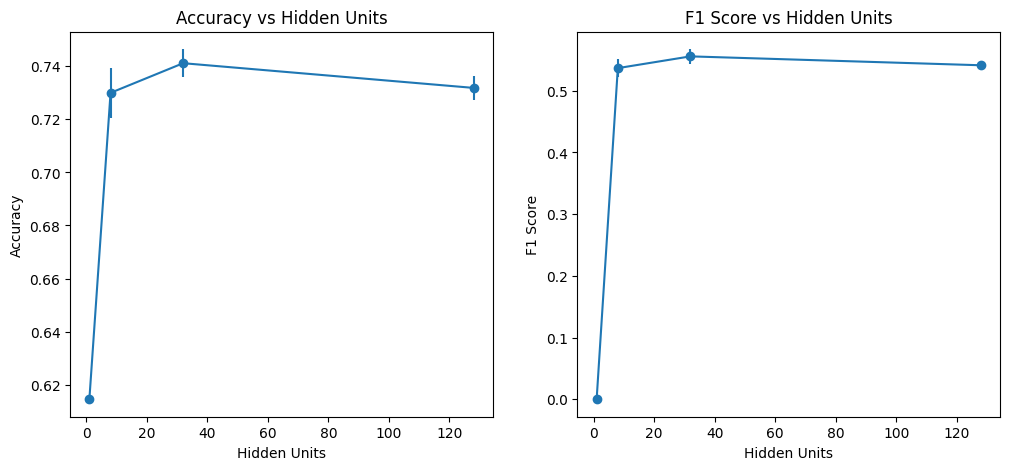

H=1: Accuracy=0.6145 ± 0.0000, F1=0.0000 ± 0.0000, Training Time=5.1888 ± 0.6319 sec
H=8: Accuracy=0.7300 ± 0.0095, F1=0.5368 ± 0.0149, Training Time=2.9159 ± 0.3778 sec
H=32: Accuracy=0.7412 ± 0.0053, F1=0.5558 ± 0.0116, Training Time=1.7765 ± 0.1533 sec
H=128: Accuracy=0.7318 ± 0.0046, F1=0.5414 ± 0.0022, Training Time=1.7410 ± 0.1815 sec


In [161]:
hidden_units = [1, 8, 32, 128]

results = {}

for H in hidden_units:
    train_times, accuracies, f1_scores = [], [], []
 
    for _ in range(3):  
        model = keras.Sequential([
            layers.Dense(H, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(H, activation='relu'),
            layers.Dense(H, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        
        start_time = time.time()

        # Using keras for deep learning.
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])
        train_time = time.time() - start_time
        
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        train_times.append(train_time)
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    results[H] = {
        'train_time_mean': np.mean(train_times), 'train_time_std': np.std(train_times),
        'accuracy_mean': np.mean(accuracies), 'accuracy_std': np.std(accuracies),
        'f1_mean': np.mean(f1_scores), 'f1_std': np.std(f1_scores)
    }


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].errorbar(hidden_units, [results[H]['accuracy_mean'] for H in hidden_units],
               yerr=[results[H]['accuracy_std'] for H in hidden_units], label='Accuracy', fmt='-o')
ax[1].errorbar(hidden_units, [results[H]['f1_mean'] for H in hidden_units],
               yerr=[results[H]['f1_std'] for H in hidden_units], label='F1 Score', fmt='-o')
ax[0].set_title("Accuracy vs Hidden Units")
ax[1].set_title("F1 Score vs Hidden Units")
ax[0].set_xlabel("Hidden Units")
ax[1].set_xlabel("Hidden Units")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("F1 Score")
plt.show()

for H, res in results.items():
    print(f"H={H}: Accuracy={res['accuracy_mean']:.4f} ± {res['accuracy_std']:.4f}, "
          f"F1={res['f1_mean']:.4f} ± {res['f1_std']:.4f}, "
          f"Training Time={res['train_time_mean']:.4f} ± {res['train_time_std']:.4f} sec")


## [Q17] ROC curve of Neural Network Model 

Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4322 - loss: 0.7123 - val_accuracy: 0.3575 - val_loss: 0.7135
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4099 - loss: 0.7054 - val_accuracy: 0.3687 - val_loss: 0.7032
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4790 - loss: 0.6960 - val_accuracy: 0.5363 - val_loss: 0.6961
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5574 - loss: 0.6914 - val_accuracy: 0.5754 - val_loss: 0.6900
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6055 - loss: 0.6871 - val_accuracy: 0.6145 - val_loss: 0.6862
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6261 - loss: 0.6842 - val_accuracy: 0.6145 - val_loss: 0.6840
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6421 - loss: 0.6805 - val_accuracy: 0.6145 - val_loss: 0.6820
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 0.6816 - val_accuracy: 0.6145 - val_loss: 0.6805
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6221 - loss: 0.6601 - val_accuracy: 0.7207 - val_loss: 0.5772
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6943 - loss: 0.5911 - val_accuracy: 0.7374 - val_loss: 0.5682
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.5554 - val_accuracy: 0.7151 - val_loss: 0.5810
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.5398 - val_accuracy: 0.7374 - val_loss: 0.5763
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7264 - loss: 0.5688 - val_accuracy: 0.7374 - val_loss: 0.5760
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.5795 - val_accuracy: 0.7374 - val_loss: 0.5856
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6941 - loss: 0.5654 - val_accuracy: 0.7207 - val_loss: 0.5649
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7164 - loss: 0.5603 - val_accuracy: 0.7374 - val_loss: 0.5868
Ep

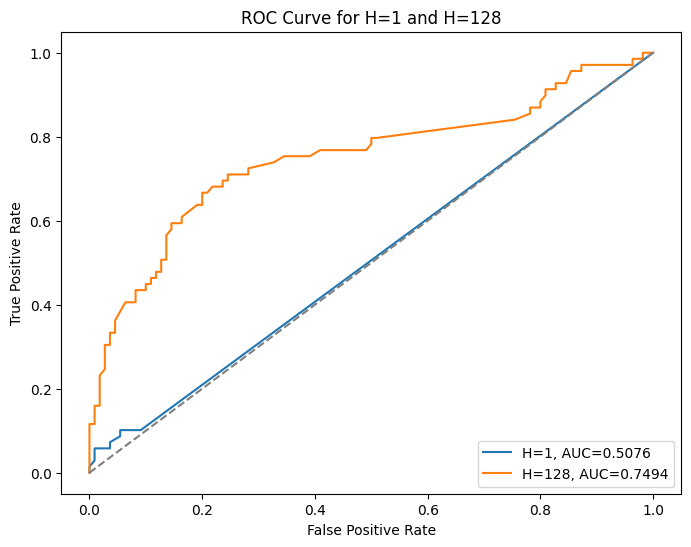

In [162]:
# Relvant hidden layer sizes.
hidden_layer_sizes = [1, 128]

roc_data = {}

for H in hidden_layer_sizes:
    model = keras.Sequential([
        layers.Dense(H, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(H, activation='relu'),
        layers.Dense(H, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    
    y_prob = model.predict(X_val)
    
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_data[H] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

plt.figure(figsize=(8, 6))
for H in hidden_layer_sizes:
    plt.plot(roc_data[H]['fpr'], roc_data[H]['tpr'], label=f'H={H}, AUC={roc_data[H]["auc"]:.4f}')
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for H=1 and H=128')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Bonus

## [Q18] Preprocessing Validation: Combination A

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       104
           1       0.71      0.87      0.78        75

    accuracy                           0.79       179
   macro avg       0.80      0.80      0.79       179
weighted avg       0.81      0.79      0.79       179



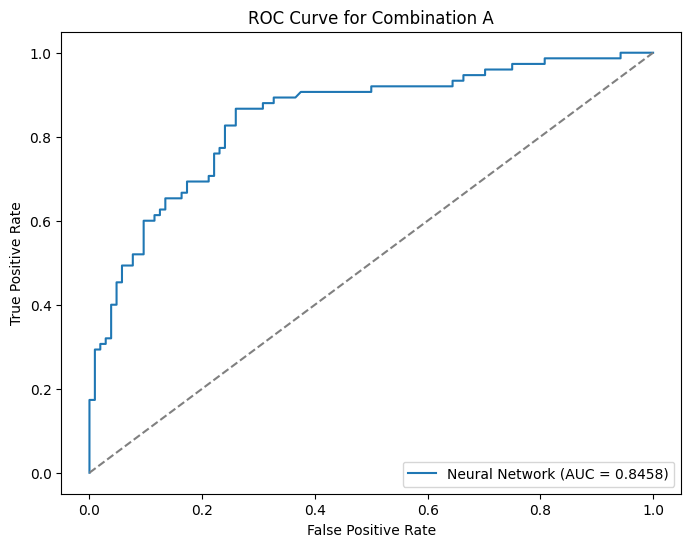

In [163]:
# Remove features with more than 70% missing values
missing_threshold = 0.7  # 70% threshold
missing_ratio = bonus_df.isnull().mean()  # Get percentage of missing values
X = bonus_df.drop(columns=missing_ratio[missing_ratio > missing_threshold].index)  # Drop columns exceeding threshold

# Separate target variable
X = X.drop('class_target', axis=1)
y = bonus_df['class_target']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211)

# Identify numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Neural network model pipeline
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(128, 128, 128), max_iter=500, random_state=4211))
])

# Train and evaluate the model
nn_pipeline.fit(X_train, y_train)
nn_predictions = nn_pipeline.predict(X_val)
nn_report = classification_report(y_val, nn_predictions)
print("Neural Network Classification Report:")
print(nn_report)

# Compute ROC curve and AUC
nn_prob = nn_pipeline.predict_proba(X_val)[:, 1]
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Combination A')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## [Q19] Preprocessing Validation: Combination B

Accuracy: 0.7932960893854749

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       104
           1       0.72      0.83      0.77        75

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.79      0.79       179



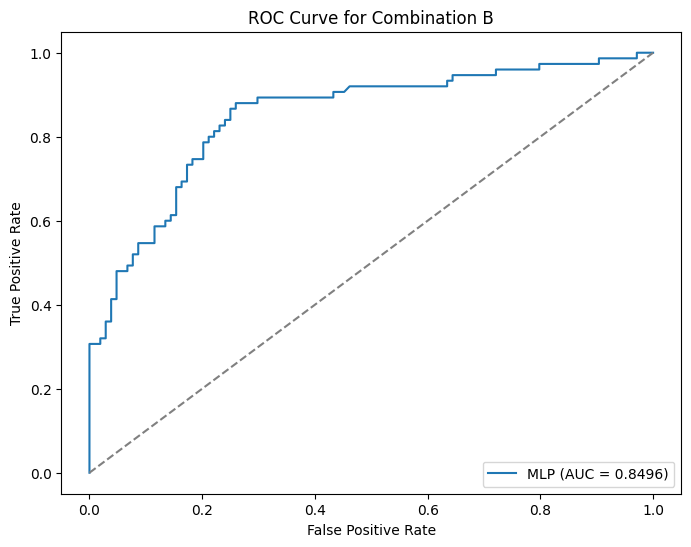

In [164]:
# Remove features with more than 70% missing values
missing_threshold = 0.7  # 70% threshold
missing_ratio = bonus_df.isnull().mean()  # Get percentage of missing values
X = bonus_df.drop(columns=missing_ratio[missing_ratio > missing_threshold].index)  # Drop columns exceeding threshold

X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipeline for numerical features.
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features.
categorical_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining the pipelines.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Combining preprocessor pipeline and MLPClassifier. 
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=4211, hidden_layer_sizes=(100, 100, 100), max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_prob = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Combination B')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## [Q20] Preprocessing Validation: Custom Combination 

Accuracy: 0.7821229050279329

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       104
           1       0.76      0.71      0.73        75

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



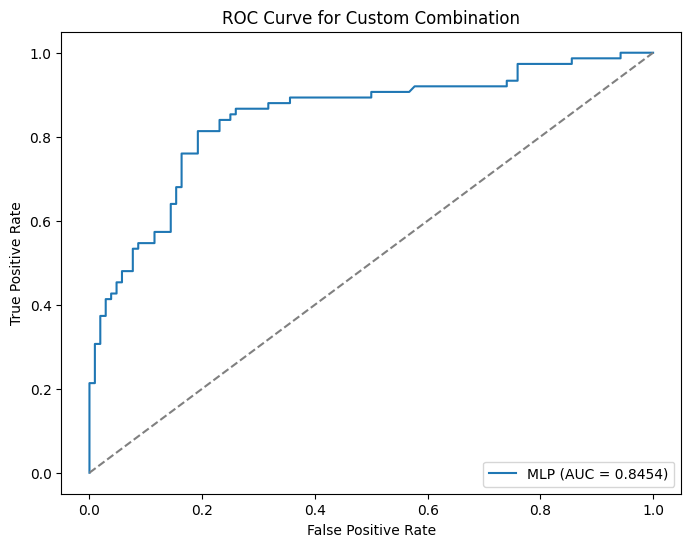

In [165]:
missing_threshold = 0.7 
missing_ratio = bonus_df.isnull().mean()
X = bonus_df.drop(columns=missing_ratio[missing_ratio > missing_threshold].index)

X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

categorical_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

feature_selection_pipeline = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.01))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection_pipeline),
    ('classifier', MLPClassifier(random_state=4211, hidden_layer_sizes=(100, 100, 100), max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_prob = model_pipeline.predict_proba(X_test)[:, 1]   
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Custom Combination')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## [Q21] Hyperparameter Tuning

In [ ]:
X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler()) 
])

categorical_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

mlp = MLPClassifier(random_state=4211, early_stopping=True)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

param_grid = {
    'classifier__hidden_layer_sizes': [(64, 64, 64), (128, 128, 128), (100, 100, 100), (256, 128, 64)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

top5_results = results[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)
print("Top 5 Hyperparameter Settings:")
print(top5_results)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nBest Hyperparameter Setting: {best_params}")
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
